In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import sys
import pandas as pd
import os
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare data

In [23]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [24]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [25]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [26]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

In [27]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [28]:
def normalize_weights(w, var, gamma):
    return w * gamma / np.sqrt(var + 0.0001)

In [29]:
def normalize_bias(b, mean, var, beta, gamma):
    return (b - mean) * (gamma / np.sqrt(var + 0.0001)) + beta

In [30]:
def relu(z):
    return np.maximum(0, z)

## Predictions

### Unencrypted

In [31]:
weights = np.load('relu_weights.npy')
#w1, b1, gamma, beta, mean, var, w2, b2 = weights
w1, b1, w2, b2 = weights

In [11]:
w_norm = normalize_weights(w1, var, gamma)
b_norm = normalize_bias(b1, mean, var, beta, gamma).reshape(1, -1)

In [12]:
layer1_clear = X_test.dot(w_norm) + b_norm
print(layer1_clear.max(), layer1_clear.min())
layer1_clear = relu(layer1_clear)
pred_clear = layer1_clear.dot(w2) + b2

4.176288321037919 -8.274213104835175


In [32]:
layer1_clear = X_test.dot(w1) + b1
print(layer1_clear.max(), layer1_clear.min())
layer1_clear = relu(layer1_clear)
pred_clear = layer1_clear.dot(w2) + b2

5.311841279902278 -9.79849761940485


In [33]:
pred_clear = y_scaler.inverse_transform(pred_clear.flatten())

In [34]:
msse_clear = msse(pred_clear, y_test)
print('MSSE relu clear: {}'.format(msse_clear))

MSSE relu clear: 53.451427826742325


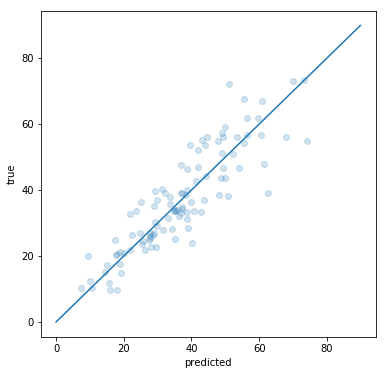

In [35]:
plot_predictions(pred_clear, y_test, save_as='concrete_clear.pdf')

### Encrypted

In [43]:
X_test_enc = EA(X_test, to_encrypt=True)
w_norm_enc = EA(w1)
b_norm_enc = EA(b1.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [44]:
layer1_enc = X_test_enc.dot(w_norm_enc) + b_norm_enc

In [45]:
layer1_enc = layer1_enc.relu()

In [46]:
pred_enc = layer1_enc.dot(w2_enc) + b2_enc
pred_enc = y_scaler.inverse_transform(pred_enc.values().flatten())

In [47]:
msse_enc = msse(pred_enc, y_test)
print('MSSE relu encrypted: {}'.format(msse_enc))

MSSE relu encrypted: 64.3475082957437


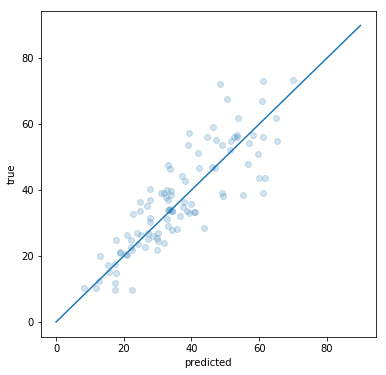

In [48]:
plot_predictions(pred_enc, y_test, save_as='concrete_enc.pdf')